**To do:**
* ~~Expand dataset -> Use Q2 prompts as well~~
    * ~~Train/Val or Train/Val/Test~~
* ~~Expand to multilabel prediction~~
* More epochs
* Check if NPU acceleration is usable (often not with small matrices
* Test with absolute loss instead of MSE
* Round outputs to nearest decimal/floor to number beofore dedimal pt -> check performance (test run)
* Calculate loss over epoch/loss per batch
* Validate -> after each training epoch
* NLP cleanups
    * Text cleanup (spelling/grammar/punctuation errors)
    * Check max length of answers
* Try different language models
* Try different network architectures/activation functions
    * TanH -> ReLU or vice versa
* Show significant tokens

## Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
from matplotlib import pyplot as plt
import logging
logging.basicConfig(level=logging.ERROR)

### Data Import and Filtering

In [3]:
# Clean up the 2 datasets
df1 = pd.read_excel("3 Watching More Closely - human coded complete - already published/Watching More Closely Data MSA.xlsx")
df2 = pd.read_excel("4 VR Coffee Without Words/5 VEC Data MSA.xlsx")

# Drop unnecessary rows and columns
df1.drop(columns = ["ID", "DataSet ", "V1", "Q1.4", "Q1.8", "Q2.4", "Q2.8", "Unnamed: 13", "Unnamed: 22",
                    "Q1_letter_count", "Q1_word_count", "Q2_letter_count", "Q2_word_count"], inplace = True)
df1.drop([0], inplace = True)
df1.dropna(axis = 0, inplace = True)

for col in list(df1.columns)[2:]:
    df1 = df1[df1[col] > -1]

df2_cols_remove = list(df2.columns)
df2_cols_keep = ['CJ_tend', 'CJ_abil', 'CJ_tend_cog_self', 'CJ_tend_aff_self', 'CJ_tend_int_self',
                    'CJ_tend_cog_target', 'CJ_tend_aff_target', 'CJ_tend_int_target',
                    'CJ_abil_cog_self', 'CJ_abil_aff_self', 'CJ_abil_int_self',
                    'CJ_abil_cog_target', 'CJ_abil_aff_target', 'CJ_abil_int_target']
for col in df2_cols_keep:
    if col in df2_cols_remove:
        df2_cols_remove.remove(col)
df2.drop(columns = df2_cols_remove, inplace = True)
df2.dropna(inplace = True)

In [4]:
data1_1 = pd.DataFrame()
data1_2 = pd.DataFrame()
data2_1 = pd.DataFrame()
data2_2 = pd.DataFrame()

df1_q1_cols = ["Q1", "Q1.1", "Q1.2", "Q1.3", "Q1.5", "Q1.6", "Q1.7"]
df1_q2_cols = ["Q2", "Q2.1", "Q2.2", "Q2.3", "Q2.5", "Q2.6", "Q2.7"]
df2_q1_cols = ["CJ_tend", "CJ_tend_aff_target", "CJ_tend_cog_target", "CJ_tend_int_target",
           "CJ_tend_aff_self", "CJ_tend_cog_self", "CJ_tend_int_self"]
df2_q2_cols = ["CJ_abil", "CJ_abil_aff_target", "CJ_abil_cog_target", "CJ_abil_int_target",
           "CJ_abil_aff_self", "CJ_abil_cog_self", "CJ_abil_int_self"]

colNames = ["Q", "AFF_TAR", "COG_TAR", "INT_TAR", "AFF_OTH", "COG_OTH", "INT_OTH"]

for i in range(len(colNames)):
    data1_1[colNames[i]] = df1[df1_q1_cols[i]]
    data1_2[colNames[i]] = df1[df1_q2_cols[i]]
    data2_1[colNames[i]] = df2[df2_q1_cols[i]]
    data2_2[colNames[i]] = df2[df2_q2_cols[i]]

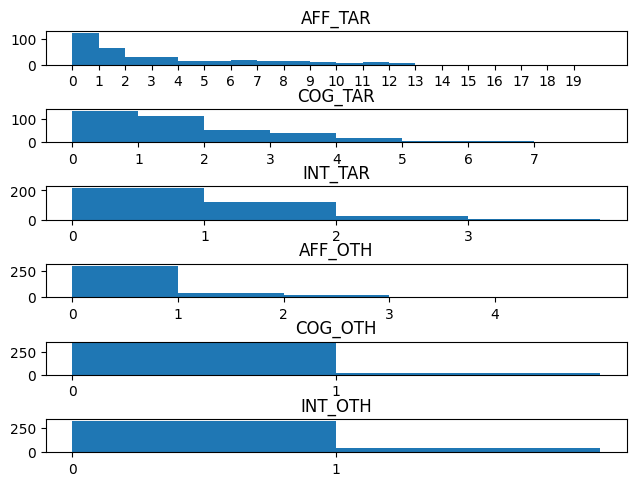

In [5]:
# Final dataset
df = pd.concat([data1_1, data1_2, data2_1, data2_2])
df.reset_index(drop=True, inplace=True)

fig, axs = plt.subplots(6,1)
fig.tight_layout()
for i, col in enumerate(list(df.columns)[1:]):
    axs[i].hist(df[col], bins = max(df[col]))
    axs[i].set_xticks(range(max(df[col])))
    axs[i].set_title(col)    

In [7]:
df.head()

,Q,AFF_TAR,COG_TAR,INT_TAR,AFF_OTH,COG_OTH,INT_OTH
0,"A child and a man, presumably the father, are ...",1,0,0,0,0,0
1,Scene opens with a father and daughter riding ...,1,1,0,0,0,0
2,The clip commences with a cross view of the gi...,0,3,1,1,0,0
3,A girl cycles with her father to see him off a...,0,1,1,0,0,0
4,A father and daughter are cycling through the ...,1,0,1,0,0,1


In [6]:
# Convert to vectorized targets
vectData = pd.DataFrame()
vectData["text"] = df["Q"]
vectData["labels"] = df.iloc[:,1:8].values.tolist()

# Train/val split
from sklearn.model_selection import train_test_split
trainData, testData = train_test_split(vectData, test_size = 0.2)
trainData.reset_index(drop = True, inplace = True)
testData.reset_index(drop = True, inplace = True)

In [7]:
trainData.head()

,text,labels
0,from the girls perspective i would have felt e...,"[8, 2, 0, 0, 0, 0]"
1,We are cycling down in the countryside my fath...,"[7, 3, 0, 0, 0, 0]"
2,The girl is helping the boy get cookies. She i...,"[0, 1, 1, 0, 0, 0]"
3,I would describe her feelings as mainly sadnes...,"[8, 4, 0, 0, 0, 0]"
4,A father and daughter go on a cycling trip. Th...,"[3, 1, 0, 0, 0, 0]"


In [8]:
# Clear memory
del(df1, df2, data1_1, data1_2, data2_1, data2_2, df)

In [44]:
names1 = {
    "Q1.1": "aff_tar", "Q1.2": "cog_tar", "Q1.3": "int_tar", "Q1.5": "aff_oth",
     "Q1.6": "cog_oth", "Q1.7": "int_oth"
}

df1 = pd.read_excel("DATA/WMC_DATA_MSA_DF.xlsx")
len1 = len(df1)
df1.drop(columns = ["Q1.4", "Q1.8", "Q2.4", "Q2.8",
                    "Q1_letter_count", "Q1_word_count", 
                    "Q2_letter_count", "Q2_word_count", 
                    "V1", "DataSet "], inplace = True)
df1.drop([0], inplace = True)
df1.rename(columns = names1, inplace = True)
df1.dropna(inplace = True)

df2_temp = pd.read_excel("DATA/5 VEC Data MSA.xlsx")
len2 = len(df2_temp)
df2_temp = df2_temp.dropna()
df2 = pd.DataFrame()
df2["Q1"] = df2_temp["CJ_tend"]
df2["aff_tar"] = df2_temp["CJ_tend_aff_target"]
df2["cog_tar"] = df2_temp["CJ_tend_cog_target"]
df2["int_tar"] = df2_temp["CJ_tend_int_target"]
df2["aff_oth"] = df2_temp["CJ_tend_aff_self"]
df2["cog_oth"] = df2_temp["CJ_tend_cog_self"]
df2["int_oth"] = df2_temp["CJ_tend_cog_self"]
df2.dropna(inplace = True)

# Filter out negative values
df1["total"] = df1["aff_tar"] + df1["cog_tar"] + df1["int_tar"] + df1["aff_oth"] + df1["cog_oth"] + df1["int_oth"]
df2["total"] = df2["aff_tar"] + df2["cog_tar"] + df2["int_tar"] + df2["aff_oth"] + df2["cog_oth"] + df2["int_oth"]
df1 = df1[df1.total > -1]
df2 = df2[df2.total >-1]
#df1.drop(columns = ["total"], inplace = True)
df2.drop(columns = ["total"], inplace = True)

print("Dataset 1:", len(df1), "rows")
print("Removed", len1 - len(df1), "rows\n")
print("Dataset 2:", len(df2), "rows")
print("Removed", len2 - len(df2), "rows")

Dataset 1: 128 rows
Removed 43 rows

Dataset 2: 63 rows
Removed 0 rows


In [49]:
df1.dtypes

Q1         object
Q2         object
aff_tar    object
cog_tar    object
int_tar    object
aff_oth    object
cog_oth    object
int_oth    object
Q2.1       object
Q2.2       object
Q2.3       object
Q2.5       object
Q2.6       object
Q2.7       object
total      object
dtype: object

In [39]:
df1.head()

,Q1,Q2,aff_tar,cog_tar,int_tar,aff_oth,cog_oth,int_oth,Q2.1,Q2.2,Q2.3,Q2.5,Q2.6,Q2.7
1,"A child and a man, presumably the father, are ...",We are cycling down in the countryside my fath...,1,0,0,0,0,0,7,3,0,0,0,0
2,Scene opens with a father and daughter riding ...,I imagine she'd be happy to be spending time w...,1,1,0,0,0,0,5,4,0,1,1,0
3,A father and daughter rode their bikes along a...,,0,0,0,0,0,0,-999,-999,-999,-999,-999,-999
5,The clip commences with a cross view of the gi...,"I would imagine she experiences glee at first,...",0,3,1,1,0,0,20,0,1,1,0,0
6,A girl cycles with her father to see him off a...,The girl seems to be happy to cycle along with...,0,1,1,0,0,0,6,2,0,0,0,0


In [7]:
df2.head()

,Q1,aff_tar,cog_tar,int_tar,aff_oth,cog_oth,int_oth
0,two children are stealing cookies from the jar...,0,0,1,0,0,0
1,This house seems chaotic. The boy is on a stoo...,0,1,0,0,0,0
2,"(Presumably)Mother daydreaming, distracted by ...",0,2,0,0,0,0
3,a woman is washing the dishes\nwater is spilli...,0,0,0,0,0,0
4,"A woman is washing the plates.However, the wat...",0,1,0,0,0,0


In [8]:
def plotHist(df, name):
    fig, axs = plt.subplots(1,6)
    fig.suptitle("Movie: " + name)
    fig.tight_layout()
    cols = [df.columns][0]
    for i in range(6):
        axs[i].hist(df[cols[i+1]])
        axs[i].set_title(cols[i+1])


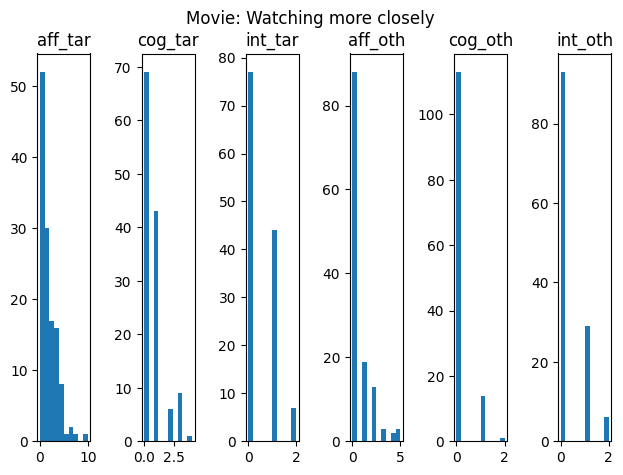

In [9]:
plotHist(df1, "Watching more closely")

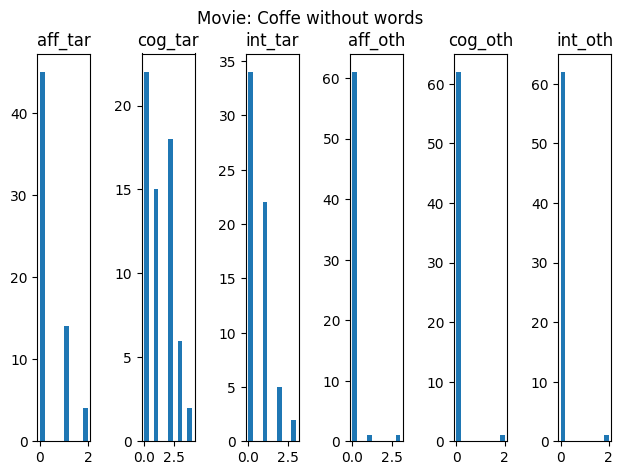

In [10]:
plotHist(df2, "Coffe without words")

## TrainingLoader Setup

In [9]:
# Params
# To do: Look into tokenizer params
MAX_LEN = 256
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

In [10]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [38]:
# Create dataset
trainSingle = MultiLabelDataset(trainDataSingle, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader_single = DataLoader(trainSingle, **train_params)

In [39]:
class nn_single(torch.nn.Module):
    def __init__(self):
        super(nn_single, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.scoreOut = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.scoreOut(pooler)
        return output

model_single = nn_single()

In [42]:
model_single

nn_single(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [57]:
# Training loop
# To do: send tensors to device
EPOCHS = 1
lossVals = []
roundVals = True

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params = model_single.parameters(), lr=1e-4)

model_single.train()
pass # somehow block cant rerun without this
for i in range(EPOCHS):
    for idx, data in enumerate(training_loader_single, 0):
        #print(data)
        ids = data['ids']
        mask = data['mask']
        token_type_ids = data['token_type_ids']
        targets = data['targets']
        targets = targets.reshape(-1,1) # Put in same shape as output

        outputs = model_single(ids, mask, token_type_ids)
        if roundVals == True: outputs = outputs.round()
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        lossVals.append(loss.item())

    print("Epoch", i, ":\tLoss:", loss.item())


Epoch 0 :	Loss: 1.0


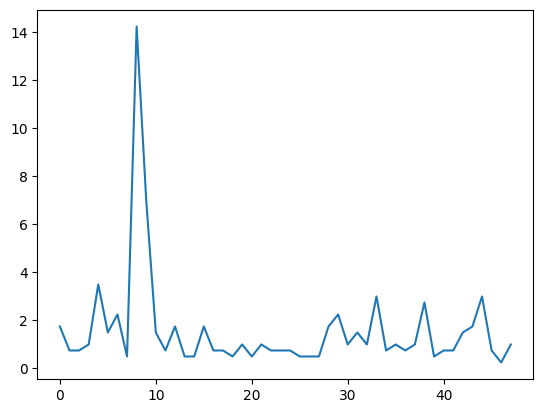

In [58]:
plt.plot(lossVals)

## Multiple Attribute Prediction

In [13]:
# Create dataset
train_multi = MultiLabelDataset(trainData, tokenizer, MAX_LEN)
test_multi = MultiLabelDataset(testData, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(train_multi, **train_params)
test_loader = DataLoader(test_multi, **train_params)

In [14]:
class nn_multi(torch.nn.Module):
    def __init__(self):
        super(nn_multi, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.hiddenFCN = torch.nn.Linear(768,768)
        self.scoreOut = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.hiddenFCN(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.scoreOut(pooler)
        return output

model_multi = nn_multi()

In [15]:
model_multi

nn_multi(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featur

In [19]:
# Training loop
# To do: send tensors to device
EPOCHS = 40
trainLoss = []
testLoss = []
#roundVals = True

loss_fn = torch.nn.MSELoss() # Use MSE since we're doing regression
optimizer = torch.optim.Adam(params = model_multi.parameters(), lr=1e-4)

for i in tqdm(range(EPOCHS)):
    model_multi.train()
    runningLossTrain = []
    runningLossVal = []
    for it, dataTrain in enumerate(training_loader):
        #print(data)
        ids = dataTrain['ids']
        mask = dataTrain['mask']
        token_type_ids = dataTrain['token_type_ids']
        targets = dataTrain['targets']

        outputs = model_multi(ids, mask, token_type_ids)
        outputs = outputs.sum(dim=1)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        runningLossTrain.append(loss.item())

    model_multi.eval()
    for it, dataVal in enumerate(test_loader):
        ids = dataVal['ids']
        mask = dataVal['mask']
        token_type_ids = dataVal['token_type_ids']
        targets = dataVal['targets']

        outputs = model_multi(ids, mask, token_type_ids)
        outputs = outputs.sum(dim=1)
        loss = loss_fn(outputs, targets)

        runningLossVal.append(loss.item())

    trainLoss.append(sum(runningLossTrain) / it)
    testLoss.append(sum(runningLossVal) / it)

    if(i % 5 == 0):
        print("Epoch", i, ":\tTrain loss:", round(trainLoss[-1], 5),
              "\tEval loss:", round(testLoss[-1], 5))


  0%|          | 0/40 [00:00<?, ?it/s]

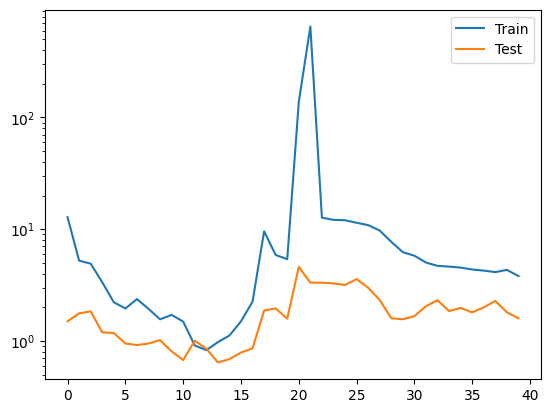

In [25]:
names = ["Train", "Test"]
plt.plot(trainLoss)
plt.plot(testLoss)
plt.yscale("log")
plt.legend(names)

In [29]:
# Save model
torch.save(model_multi, "model_FCN_TANH_RELU")

## Testing

In [68]:
# Load model
model_multi = torch.load("model_FCN_TANH_RELU.pt")
model_multi.eval()
loss_fn = torch.nn.MSELoss() # Use MSE since we're doing regression
optimizer = torch.optim.Adam(params = model_multi.parameters(), lr=1e-4)

# Visualization
labels = []
outputs_raw = []
outputs_rnd = []
outputs_flr = []

# Run on test set and visualize output vectors (with and without rounding/flooring)
for it, dataVal in enumerate(tqdm(test_loader)):
    ids = dataVal['ids']
    mask = dataVal['mask']
    token_type_ids = dataVal['token_type_ids']
    targets = dataVal['targets']

    outputs = model_multi(ids, mask, token_type_ids)
    outputs = outputs.sum(dim=1)
    loss = loss_fn(outputs, targets)

    outputs_no_grad = torch.tensor(outputs, requires_grad = False)
    outputs_raw.append(outputs_no_grad)
    outputs_rnd.append(torch.round(outputs_no_grad))
    outputs_flr.append(torch.floor(outputs_no_grad))
    labels.append(targets)
    
    #if(it == 9): break

  0%|          | 0/74 [00:00<?, ?it/s]

In [79]:
# Write results to .txt file
fileName = "ToM_out_1.txt"

for i in range(len(labels)):
    with open(fileName, "a") as log:
        log.write("True label:\t\t" + str(labels[i]) + "\n")
        log.write("Floored output:\t\t" + str(outputs_flr[i]) + "\n")
        log.write("Rounded output:\t\t" +str(outputs_rnd[i]) + "\n")
        log.write("Raw output:\t\t" +str(outputs_raw[i]) + "\n\n")